In [1]:
import os
import pandas as pd
import numpy as np
from scipy import stats
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
os.chdir(r'C:\Users\bakch\Downloads\facebook')

In [3]:
def read_circles(file_path):
    with open(file_path) as f :
        content = f.readlines()
        content = [line.replace("\n","") for line in content]
        content = [line.split("\t") for line in content]
    return {circle[0]:list(map(int,circle[1:])) for circle in content}

In [4]:
E = nx.read_edgelist('107.edges', nodetype=int)
circles = read_circles("107.circles")

In [5]:
G = nx.Graph()
G.add_edges_from(E.edges)

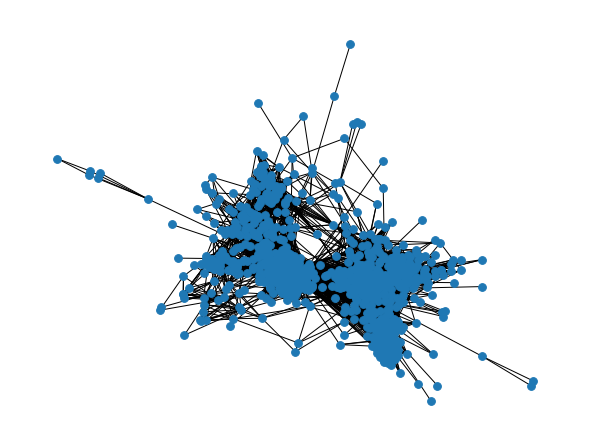

In [6]:
# plt.figure(figsize=(5,3))

# nx.draw(G, node_color='lightblue', with_labels=True, node_size=400)

plt.figure(figsize=(8,6))
nx.draw(G, node_size=60)

In [7]:
# network properties

# reciprocity: tendency for directed ties from actor i to actor j be reciprociated and sent back from actor j to actor i
print(nx.reciprocity(G)) # 0 because it is an undirected network

# transitivity: tendency for friends of friends to be friends and enemies of enemies to be enemies. 
# two nodes being connected to a third increases the likelihood that they will connect themselves.
# the extent to which nodes tend to form triangles or clusters of connections
# a moderate level of clustering in the network
print(nx.transitivity(G))

# preferential attachment: tendency for nodes that are already central to gain more connections at a greater rate than those who are not already central. 
preferential_attachment = nx.preferential_attachment(G)
print(next(preferential_attachment))

# structural equivalence: actors occupying the same position in the network relative to all other actors.

# clique: a subset of actors in a network such that every two actors in the subset are connected by a tie.
print(next(nx.enumerate_all_cliques(G)))

0.0
0.5045088189930924
(0, 348, 34)
[953]


In [8]:
# A graph is commonly classified as small-world if sigma > 1
# print(nx.sigma(G))

In [9]:
# degree centrality: number of direct, immediate connections a node has to other nodes within the network
# e.g., high degree centrality = large number of friends on Facebook
# how many direct connections a node has
degree_centrality = nx.degree_centrality(G)
max(degree_centrality.items())

(1911, 0.036786060019361085)

In [10]:
max(degree_centrality.items())[1]

0.036786060019361085

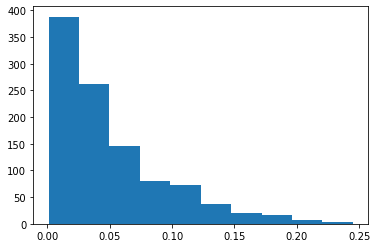

In [11]:
data_degree = list(degree_centrality.values())

num_bins=10

plt.hist(data_degree, num_bins)

plt.show()

In [12]:
# betweenness centrality: the extent to which a node lies on paths between other nodes
# quantifies how often a node acts as a bridge along the shortest path between two other nodes
# calculation: given all shortest paths in the network, how many times a particular node falls on these paths?
# a node with high betwenness centrality may have lower degree centrality
# how often a node serves as "a connector" along the shortest route
betweenness_centrality = nx.betweenness_centrality(G)
max(betweenness_centrality.items())

(1911, 0.0022616887050621575)

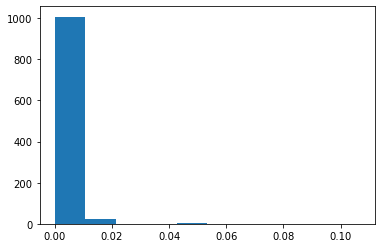

In [13]:
data_betweenness = list(betweenness_centrality.values())

plt.hist(data_betweenness, num_bins)

plt.show()

In [14]:
# closeness centrality: measures how close a node is to all other nodes in the network
# nodes with a high closeness centrality can quickly interact with all others
# reciprocal of the sum of the shortest path distances from the node to all other nodes
# a city with high closeness centrality would be one that has short travel times to all other cities in the network
# how "quickly" a node can interact
closeness_centrality = nx.closeness_centrality(G)
max(closeness_centrality.items())

(1911, 0.3515997277059224)

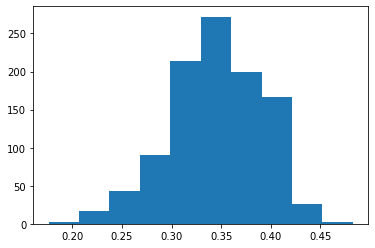

In [15]:
data_closeness = list(closeness_centrality.values())

plt.hist(data_closeness, num_bins)

plt.show()

In [16]:
# eigenvector centrality: 
# numbre of connections a node has (e.g., degree centrality) + quality of these connections
# a paper with high eigenvector centrality is one that is cited by other papers that have high scores
# if a paper is cited by other highly influential papers, it is considered more central.
# how "influential" a node is, considering bot the number and the quality of its connections

In [17]:
eigenvector_centrality_numpy = nx.eigenvector_centrality_numpy(G)
max(eigenvector_centrality_numpy.items())

(1911, 0.006236405490703265)

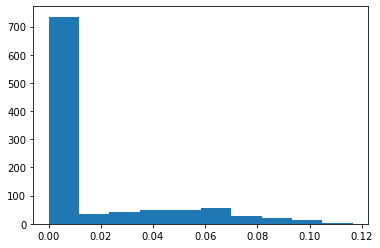

In [18]:
data_eigenvector = list(eigenvector_centrality_numpy.values())
plt.hist(data_eigenvector, num_bins)

plt.show()

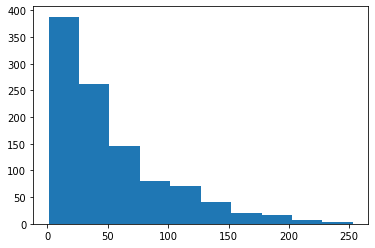

In [19]:
data_degree = [x[1] for x in list(G.degree)]

plt.hist(data_degree, num_bins)

plt.show()

In [20]:
# betweenness centrality vs. brokerage centrality
# path vs. group connection

# types of brokerage relationships
# coordinator
# gatekeeper
# representative
# liaison (or consultant)
# itinerant broker

In [21]:
df_centrality = pd.DataFrame(degree_centrality.values(), degree_centrality.keys()).reset_index()

df_centrality.columns = ['node_id', 'degree_centrality']

In [22]:
centrality_measures = {
    'betweenness_centrality': betweenness_centrality,
    'closeness_centrality': closeness_centrality,
    'eigenvector_centrality': eigenvector_centrality_numpy,
    'node_degree': dict(G.degree)
}

# Applying the mapping to create new columns in df_centrality
for column, function in centrality_measures.items():
    df_centrality[column] = df_centrality['node_id'].map(function)

In [23]:
df_centrality[df_centrality.node_id == 1043]

,node_id,degree_centrality,betweenness_centrality,closeness_centrality,eigenvector_centrality,node_degree
968,1043,0.010649,0.000593,0.277464,0.000006,11


In [24]:
# df_centrality.to_csv('107_centrality.csv', index=False)

In [25]:
# use PCA to identify clusters among the nodes

From PCA, we found that PC1, with high negative loading for degree centrality, explains for 85.403% of total variance. For PC2 with high negative loading for closeness centrality explains for 12.112% of total variance.

K-means Clustering suggests that Cluster 1 is composed of nodes with less number of ties than Cluster 2, while both clusters not close to each other.

### Summaries of each circle

In [26]:
def build_graph_and_summarize(circle_group):
    subgraph = circles[circle_group]
    edgelist = list(G.edges())

    induced_edges = []

    for edge in edgelist:
        if ((edge[0] in subgraph) and (edge[1] in subgraph)):
            induced_edges.append(edge)
            
    G_new = nx.Graph()

    G_new.add_nodes_from(subgraph)
    G_new.add_edges_from(induced_edges, nodetype=int)

    # draw a network
    plt.figure(figsize=(5, 3))
    nx.draw(G_new, node_size=30)
    print(str(circle_group))
    plt.show()
    
    # centrality characteristics
    num_bins = 10
    #degree centrality
    degree_centrality = nx.degree_centrality(G_new)
    plt.hist(data_degree, num_bins)
    print("Degree Centrality")
    plt.show()
    
    #betweenness centrality
    betweenness_centrality = nx.betweenness_centrality(G_new)
    data_betweenness = list(betweenness_centrality.values())
    plt.hist(data_betweenness, num_bins)
    print("Betweenness Centrality")
    plt.show()

    #closeness centrality
    closeness_centrality = nx.closeness_centrality(G_new)
    data_closeness = list(closeness_centrality.values())
    plt.hist(data_closeness, num_bins)
    print("Closeness Centrality")
    plt.show()

    #eigenvector centrality
    eigenvector_centrality_numpy = nx.eigenvector_centrality_numpy(G_new)
    data_eigenvector = list(eigenvector_centrality_numpy.values())
    plt.hist(data_eigenvector, num_bins)
    print("Eigenvector Centrality")
    plt.show()
    
    # diameter
    try:
        print("Diameter: " + str(nx.algorithms.distance_measures.diameter(G_new)))
    except:
        print("Found infinite path length because the graph is not connected.")
        
    # number of nodes
    print("Number of nodes: " + str(G_new.number_of_nodes()))
    
    #number of edges
    print("Number of edges: " + str(G_new.number_of_edges()))
    
    #number of connected components
    nocc = nx.number_connected_components(G_new)
    print("Number of connected components: " + str(nocc))
    
    # largest connected component
    
    print("Largest connected component: " + str(max([len(i) for i in list(nx.connected_components(G_new))])))

circle0


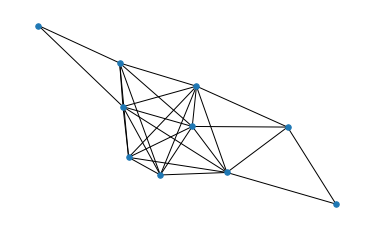

Degree Centrality


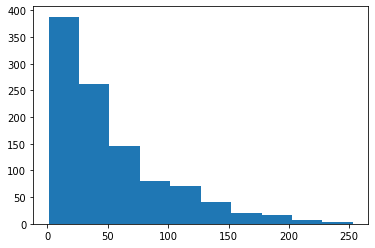

Betweenness Centrality


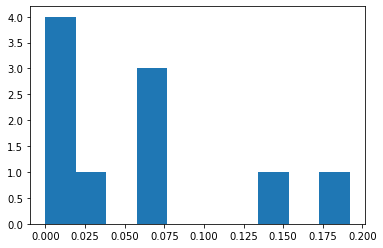

Closeness Centrality


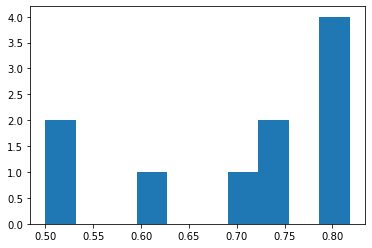

Eigenvector Centrality


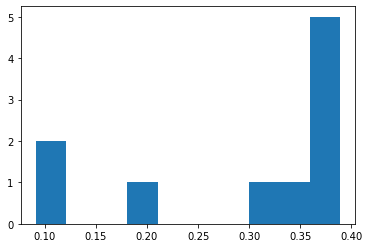

Diameter: 3
Number of nodes: 10
Number of edges: 27
Number of connected components: 1
Largest connected component: 10


In [27]:
build_graph_and_summarize('circle0')

circle1


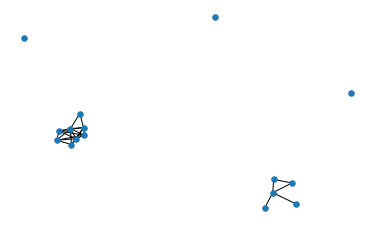

Degree Centrality


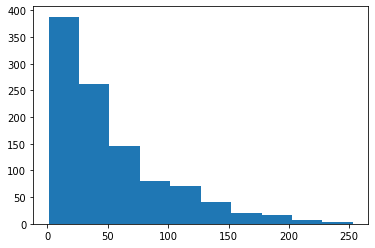

Betweenness Centrality


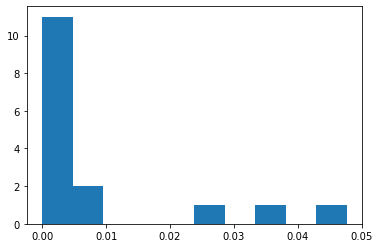

Closeness Centrality


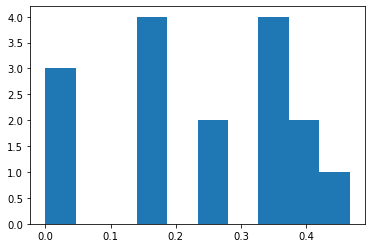

Eigenvector Centrality


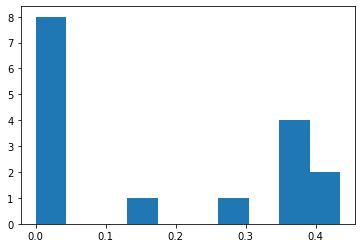

Found infinite path length because the graph is not connected.
Number of nodes: 16
Number of edges: 25
Number of connected components: 5
Largest connected component: 8


In [28]:
build_graph_and_summarize('circle1')

circle2


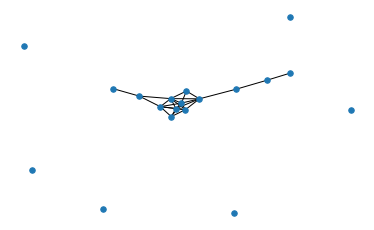

Degree Centrality


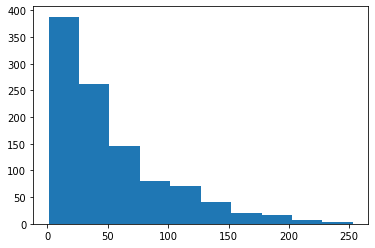

Betweenness Centrality


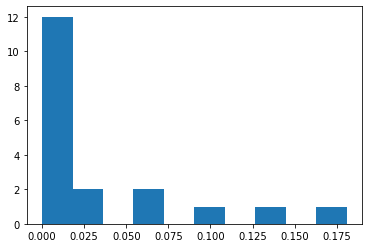

Closeness Centrality


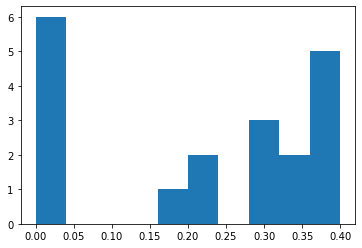

Eigenvector Centrality


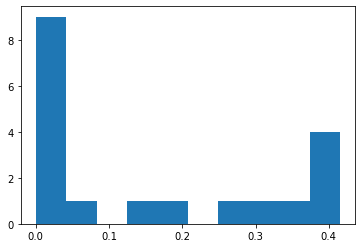

Found infinite path length because the graph is not connected.
Number of nodes: 19
Number of edges: 27
Number of connected components: 7
Largest connected component: 13


In [29]:
build_graph_and_summarize('circle2')

circle3


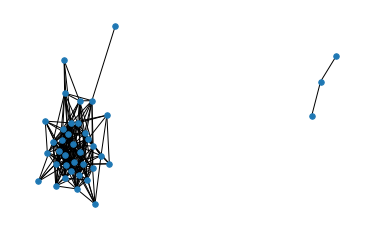

Degree Centrality


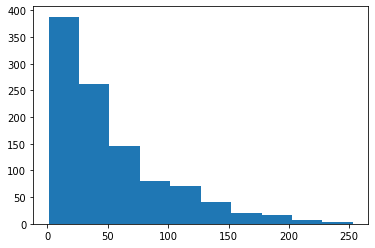

Betweenness Centrality


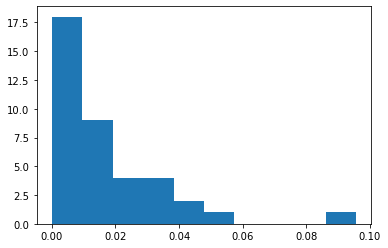

Closeness Centrality


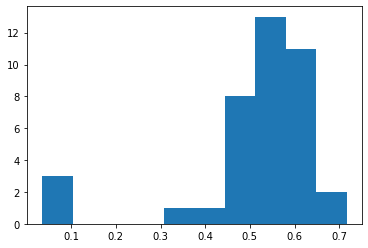

Eigenvector Centrality


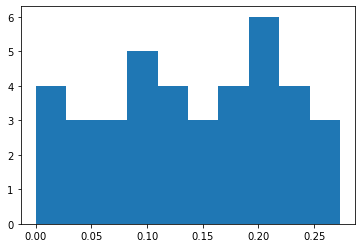

Found infinite path length because the graph is not connected.
Number of nodes: 39
Number of edges: 233
Number of connected components: 2
Largest connected component: 36


In [30]:
build_graph_and_summarize('circle3')

circle4


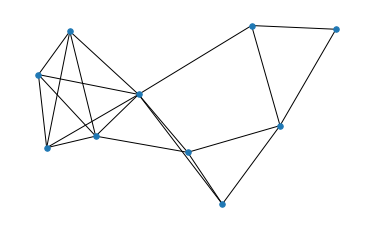

Degree Centrality


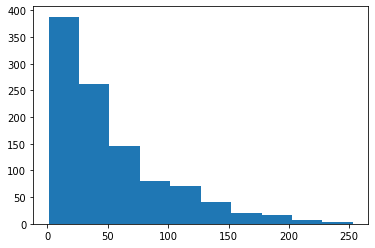

Betweenness Centrality


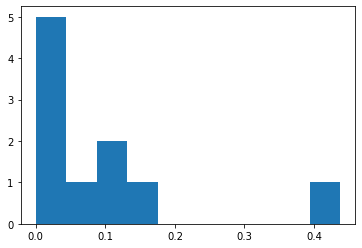

Closeness Centrality


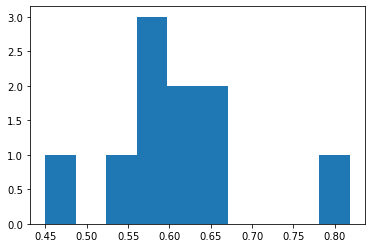

Eigenvector Centrality


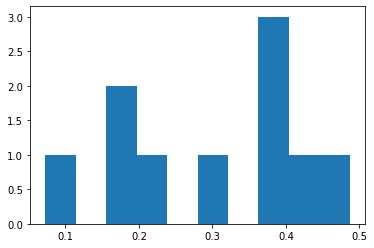

Diameter: 3
Number of nodes: 10
Number of edges: 20
Number of connected components: 1
Largest connected component: 10


In [31]:
build_graph_and_summarize('circle4')

circle5


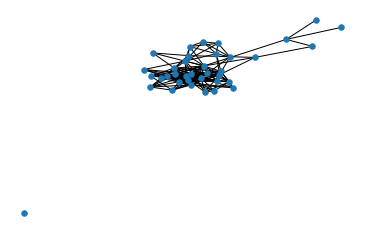

Degree Centrality


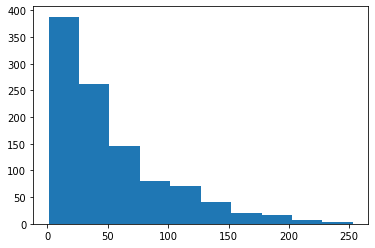

Betweenness Centrality


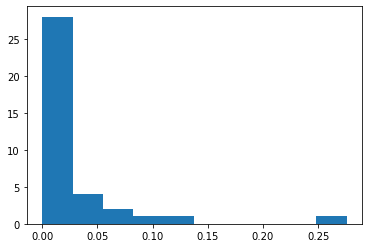

Closeness Centrality


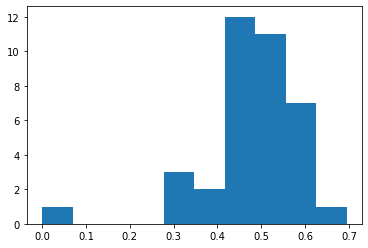

Eigenvector Centrality


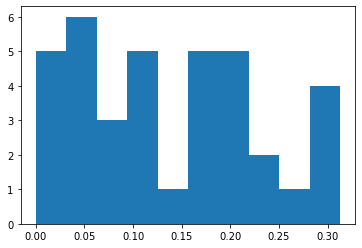

Found infinite path length because the graph is not connected.
Number of nodes: 37
Number of edges: 159
Number of connected components: 2
Largest connected component: 36


In [32]:
build_graph_and_summarize('circle5')

circle6


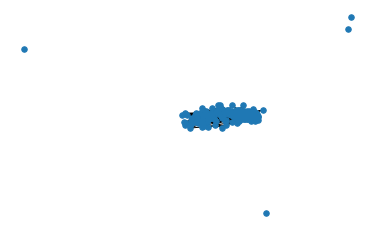

Degree Centrality


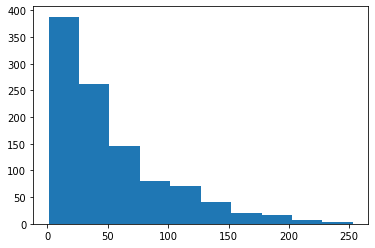

Betweenness Centrality


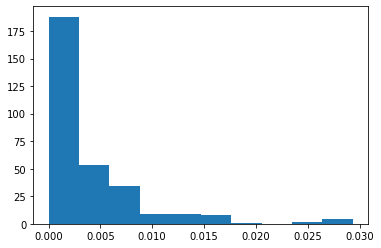

Closeness Centrality


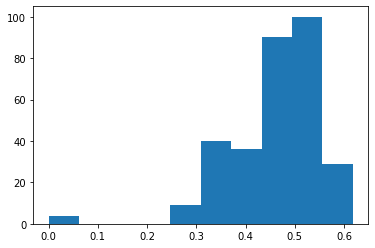

Eigenvector Centrality


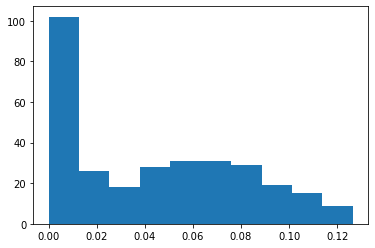

Found infinite path length because the graph is not connected.
Number of nodes: 308
Number of edges: 8612
Number of connected components: 5
Largest connected component: 304


In [33]:
build_graph_and_summarize('circle6')

circle7


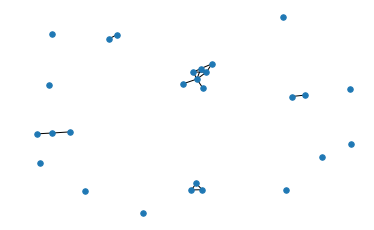

Degree Centrality


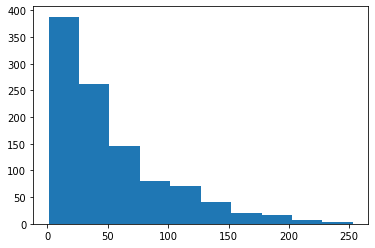

Betweenness Centrality


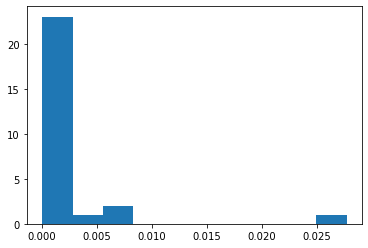

Closeness Centrality


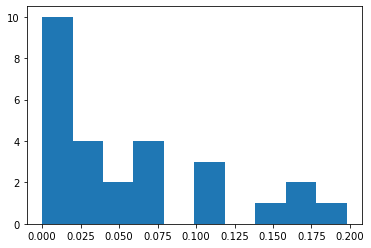

Eigenvector Centrality


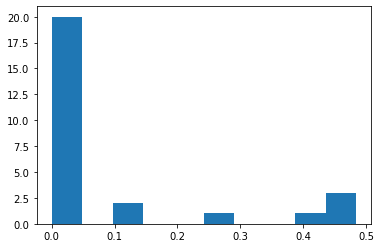

Found infinite path length because the graph is not connected.
Number of nodes: 27
Number of edges: 17
Number of connected components: 15
Largest connected component: 7


In [34]:
build_graph_and_summarize('circle7')

circle8


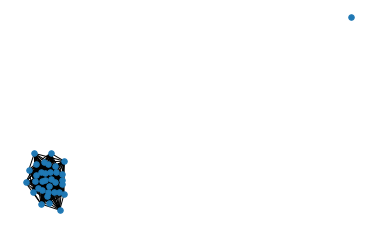

Degree Centrality


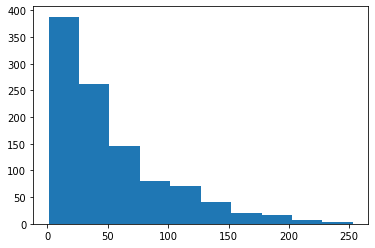

Betweenness Centrality


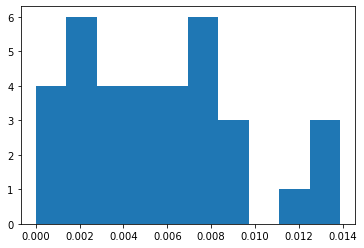

Closeness Centrality


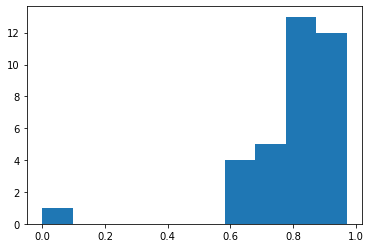

Eigenvector Centrality


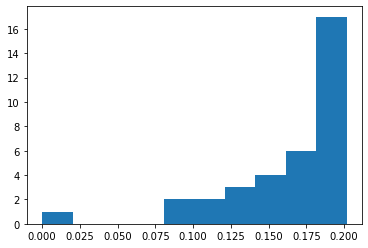

Found infinite path length because the graph is not connected.
Number of nodes: 35
Number of edges: 450
Number of connected components: 2
Largest connected component: 34


In [35]:
build_graph_and_summarize('circle8')

### circle membership prediction using node2vec  
Embeddings should capture the graph topology (i.e., relationships between nodes and further relevant information). Hence, it is important to form embeddings based on the principle of similarity, such as homophily (e.g., grouping pepole together that spend time together) or structural equivalence (e.g., two different people having the same role in each of their peer groups). Embeddings should be formed such that they reflect the information that comes from the network.  

As the random walks explore the graph, Node2Vec learns embeddings for each node in the network. The objective is to ensure that nodes with similar neighborhood structures have similar embeddings.  

The context of the node is defined by the nodes of the neighbor of that node. Two approaches in how to explore the context of the node in a graph: 1) breadth-first and 2) depth-first search, closely related to homophily and strucutral equivalence, respectively.  

However, taking into account the entire context is not possible because it will lead to capturing the entire graph. Hence, we introduce sampling stategy where we approximate the context of the node (i.e., exploring the context of the fixed number of random nodes), with a tradeoff between breadth-first and depth-first. Having the context of each node, we want to find vector representation of each node, such that node with similar context is mapped close in the embedding space (e.g., calculating the similarity of source node and neighboring nodes by taking the dot product between two vectors to quantify the degree of alignment). Then, transform the dot product into probabilities by appling softmax (normalizing number into probabilities by squashing the number between 0 and 1). Then apply this to all nodes in the graph simultaneously.  

In [36]:
from node2vec import Node2Vec

In [37]:
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix

from sklearn.metrics import roc_curve, roc_auc_score

In [38]:
def get_embeddings(G):
    node2vec = Node2Vec(G)
    model = node2vec.fit()
    
    #return embeddings
    embeddings = model.wv.vectors
    return embeddings

In [39]:
embeddings = get_embeddings(G)

Computing transition probabilities:   0%|          | 0/1034 [00:00<?, ?it/s]

Generating walks (CPU: 1): 100%|███████████████████████████████████████████████████████| 10/10 [00:09<00:00,  1.06it/s]


In [40]:
# Define a range of k values to test
k_values = range(2, 11)

# Calculate the sum of squared distances for each k
inertia_values = []
for k in k_values:
    kmeans = KMeans(n_clusters=k, random_state=0).fit(embeddings)
    inertia_values.append(kmeans.inertia_)

In [41]:
# Calculate the rate of change between consecutive k values
slope_values = [inertia_values[i] - inertia_values[i - 1] for i in range(1, len(inertia_values))]

# Find the "elbow point" where the slope starts to flatten
elbow_point = 2  # Default to the first k value
for i in range(2, len(slope_values)):
    if slope_values[i] < slope_values[i - 1]:
        elbow_point = k_values[i]
        break

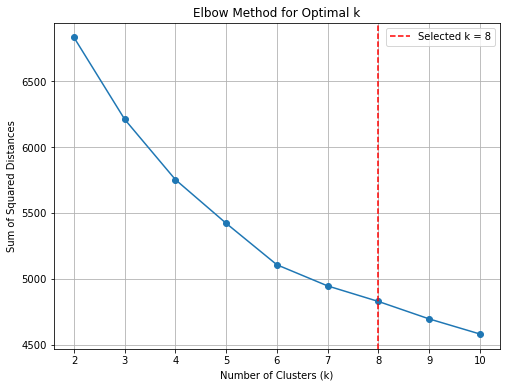

In [42]:
# Plot the elbow curve
plt.figure(figsize=(8, 6))
plt.plot(k_values, inertia_values, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Sum of Squared Distances')
plt.title('Elbow Method for Optimal k')

plt.axvline(x=elbow_point, color='red', linestyle='--', label=f'Selected k = {elbow_point}')
plt.legend()

plt.grid(True)
plt.show()

In [43]:
kmeans = KMeans(n_clusters=7, random_state=0).fit(embeddings)

In [44]:
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

# Assuming 'node_embeddings' is a NumPy array with shape (num_nodes, embedding_dimension)

# Reduce dimensionality using PCA
pca = PCA(n_components=2)  # Adjust the number of components as needed
reduced_embeddings = pca.fit_transform(embeddings)

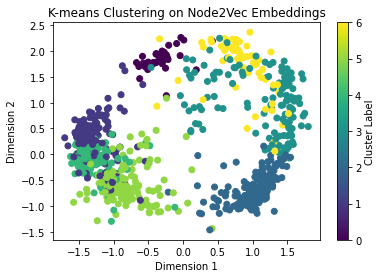

In [45]:
import matplotlib.pyplot as plt

plt.scatter(reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=kmeans.labels_)
plt.xlabel('Dimension 1')
plt.ylabel('Dimension 2')
plt.title('K-means Clustering on Node2Vec Embeddings')
plt.colorbar(label='Cluster Label')
plt.show()

In [46]:
df_kmeans = pd.DataFrame({'node_id': list(G.nodes), 'circles_kmeans': list(kmeans.labels_)})

In [47]:
def get_circle_labels(G,circles):
    circle_labels = []
    for node in G.nodes():
        is_added = False
        for i,li in enumerate(list(circles.values())):
            if node in li and not is_added:
                circle_labels.append(i)
                is_added = True
        if not is_added:
            circle_labels.append(-1)
    return circle_labels

In [48]:
X_train, X_test, y_train, y_test = train_test_split(embeddings, get_circle_labels(G, circles), test_size=0.2, random_state=1)

### supervised ML models  
Random Forest  
* decision trees: recursively split the dataset into subsets based on the values of input features, with the goal of creating leaf nodes that represent the output (i.e., class or value). It finds the best split by maximizing the entropy (information) gain; if a data sample satisfies the condition at a decision node,  then it moves to the left leaf, if not, to the right leaf.  
* boostrap aggregating (bagging): creates multiple subsets of the original dataset by random sampling with replacement (i.e., boostrap samples). Each decision tree is trained on one of these subsets.  
* random feature selection: considers only a random subset of features when making splits in each decision tree.  
* ensemble learning: combines multiple decision trees to make more accurate predictions. It leverages the idea that multiple weak learners (individual decision trees) can come together to form a stronger learner (random forest).
* voting (classification) or averaging (regression): for classification, each decision tree predicts the class label, and the final prediction is determined by majority voting. for regression, each decision tree predicts a numerical value, and the final prediction is the average of these values.
* particularly effective in handling non-linear problem due to its esnemble nature.

In [49]:
pd.DataFrame(y_train)[0].value_counts()

-1    455
 6    221
 3     33
 8     29
 5     29
 7     18
 2     13
 1     11
 0     10
 4      8
Name: 0, dtype: int64

In [50]:
# Random Forest
rf = RandomForestClassifier()
rf.fit(X_train, y_train)
y_pred_rf = rf.predict(X_test)
score = f1_score(y_test, y_pred_rf, average = None)

# harmonic mean between precision and recall
print("F1 Score: ", score)
# (TP + TN) / total; to minimize the chances of missing any true instances
print("Accuracy: " + str(accuracy_score(y_test, y_pred_rf)))
# TP / (TP + FP); innocent until proven guilty
print("Precision: " + str(precision_score(y_test, y_pred_rf, average = None)))
# TP / (TP + FN)
print("Recall: " + str(recall_score(y_test, y_pred_rf, average = None)))

F1 Score:  [0.65201465 0.         0.         0.         0.         0.
 0.32380952 0.         0.28571429]
Accuracy: 0.5169082125603864
Precision: [0.51149425 0.         0.         0.         0.         0.
 0.5483871  0.         1.        ]
Recall: [0.8989899  0.         0.         0.         0.         0.
 0.22972973 0.         0.16666667]


C:\Users\bakch\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Logistic Regression  
* logistic function (sigmoid): uses the sigmoid function (i.e., 1/(1+e^-x)) to model the relationship between the input features and the probability of the positive class. The sigmoid function maps any real-valued number to the range [0,1], making it suitable for modeling probabilities.
* training: during the training, the logistic regression model learns the optimal values of the coefficients β that maximize the likelihood of the observed data, using optimization techniques like gradient descent.  
* classification: uses a decision boundary to classify instances into one of the two classes. The threshold is often set at 0.5.  
* designed for binary classification task, but can handle multi-class classification tasks using one-vs-all (OvA) or softmax regression

In [51]:
from sklearn.linear_model import LogisticRegression

In [52]:
# Logistic Regression
lr = LogisticRegression(multi_class='multinomial', max_iter=1000)
lr.fit(X_train, y_train)
y_pred_lr = lr.predict(X_test)
score = f1_score(y_test, y_pred_lr, average = None)

# harmonic mean between precision and recall
print("F1 Score: ", score)
# (TP + TN) / total; to minimize the chances of missing any true instances
print("Accuracy: " + str(accuracy_score(y_test, y_pred_lr)))
# TP / (TP + FP); innocent until proven guilty
print("Precision: " + str(precision_score(y_test, y_pred_lr, average = None)))
# TP / (TP + FN)
print("Recall: " + str(recall_score(y_test, y_pred_lr, average = None)))

F1 Score:  [0.6171875  0.         0.         0.         0.         0.
 0.41322314 0.         0.        ]
Accuracy: 0.5024154589371981
Precision: [0.50318471 0.         0.         0.         0.         0.
 0.53191489 0.         0.        ]
Recall: [0.7979798  0.         0.         0.         0.         0.
 0.33783784 0.         0.        ]


C:\Users\bakch\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


SVM  
* in a binary classification problem, SVM seeks to find a hyperplane (a decision boundary) that best separates the data points of different classes.  
* the optimal hyperplane is the one that maximizes the margin, which is the distance between the hyperplane and the nearest data points (support vectors) from each class.  
* SVM can handle both linearly separable and non-linearly separable data by using the kernel trick, which allows SVMs to implicitly map data points into a higher-dimensional space where they become separable without acutually transforming the data to the higher dimensions, reducing the amount of computation (kernel function systematically finds support vector classifiers in higher dimensions).  
* use cross validation to determine how many misclassifications to allow inside of the soft margin (i.e., distance between the observations and the threshold) to get the best classification.

In [53]:
from sklearn.svm import SVC

In [54]:
# SVM
svm = SVC(decision_function_shape='ovr')

# regularization parameter for controlling trade-off with cross-validation
# grid_search = GridSearchCV(svm, {'C': [0.001, 0.01, 0.1, 1, 10, 100]}, cv=5)
# best_C = grid_search.best_params_['C']
svm.fit(X_train, y_train)
y_pred_svm = svm.predict(X_test)
score = f1_score(y_test, y_pred_svm, average = None)

# harmonic mean between precision and recall
print("F1 Score: ", score)
# (TP + TN) / total; to minimize the chances of missing any true instances
print("Accuracy: " + str(accuracy_score(y_test, y_pred_svm)))
# TP / (TP + FP); innocent until proven guilty
print("Precision: " + str(precision_score(y_test, y_pred_svm, average = None)))
# TP / (TP + FN)
print("Recall: " + str(recall_score(y_test, y_pred_svm, average = None)))

F1 Score:  [0.64925373 0.         0.         0.         0.         0.
 0.42857143 0.         0.        ]
Accuracy: 0.5362318840579711
Precision: [0.5147929  0.         0.         0.         0.         0.
 0.63157895 0.         0.        ]
Recall: [0.87878788 0.         0.         0.         0.         0.
 0.32432432 0.         0.        ]


C:\Users\bakch\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Naive Bayes  
* types: (a) Guassian NB is suitable for continuous data (e.g., numerical measurements, sensor data), assumes the features follow a Gaussian (normal) distribution, assumes the data is normally distributed within each class. (b) Multinomial NB is suitable for discrete data, especially with text data represented as word counts. assumes a multinomial distribution of data. (c) Bernoulli NB is suitable for binary data (e.g., spam detection or sentiment analysis), assumes Bernoulli distribution      
* makes the naive assumption of conditional independence among features given the class label, simplifying the probability calculations  
* posterior probability: P(A|B) = (P(B|A)*P(A))/P(B)
* Laplace smoothing: to handle zero probabilities for unseen feature values; adds a small constant to each feature count to ensure that no feature probability becomes zero  
* model training: learns the class priors (prior probabilities or initial guesses of each class) and the conditional probabilities of features given each class  
* predictions: calculates the posterior probabilities of each class for a given data point and assigns it to the class with the highest posterior probability  

In [55]:
from sklearn.naive_bayes import GaussianNB

In [56]:
# GNB
gnb  = GaussianNB()

gnb.fit(X_train, y_train)
y_pred_gnb = gnb.predict(X_test)
score = f1_score(y_test, y_pred_gnb, average = None)

# harmonic mean between precision and recall
print("F1 Score: ", score)
# (TP + TN) / total; to minimize the chances of missing any true instances
print("Accuracy: " + str(accuracy_score(y_test, y_pred_gnb)))
# TP / (TP + FP); innocent until proven guilty
print("Precision: " + str(precision_score(y_test, y_pred_gnb, average = None)))
# TP / (TP + FN)
print("Recall: " + str(recall_score(y_test, y_pred_gnb, average = None)))

F1 Score:  [0.29850746 0.         0.         0.         0.         0.2
 0.08333333 0.54929577 0.         0.06896552]
Accuracy: 0.2995169082125604
Precision: [0.57142857 0.         0.         0.         0.         0.125
 0.05882353 0.57352941 0.         0.04347826]
Recall: [0.2020202  0.         0.         0.         0.         0.5
 0.14285714 0.52702703 0.         0.16666667]


C:\Users\bakch\Anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [57]:
# given a small size of node data in some classes, we may consider including more data and run the models again.

Works Cited  
Okcular, E. (2021). <i>Facebook Social Circle Analysis with NetworkX</i>. GitHub. https://github.com/michelle-chaewon/social-circle/blob/main/Summaries_and_Circles.ipynb  
Boutellier, Y. (2021). <i>Node embeddings for Beginners
</i>. Towards Data Science. https://towardsdatascience.com/node-embeddings-for-beginners-554ab1625d98